# Internal Inconsistencies

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from IPython.display import display


In [2]:
import import_ipynb
import data_preperation as dp

countries={ 'Austria': 'AT', 'Belgium': 'BE',  'Bulgaria': 'BG', 'Switzerland': 'CH', 'Czech Republic': 'CZ', 'Germany': 'DE', 'Denmark': 'DK', 'Estonia': 'EE', 'Spain': 'ES', 'Finland': 'FI', 'France': 'FR',  'Greece': 'GR', 'Hungary': 'HU', 'Ireland': 'IE', 'Italy': 'IT', 'Lithuania': 'LT', 'Latvia': 'LV', 'Montenegro': 'ME','Netherlands': 'NL', 'Norway': 'NO', 'Poland': 'PL', 'Portugal': 'PT', 'Serbia': 'RS', 'Sweden': 'SE', 'Slovenia': 'SI', 'Slovakia': 'SK', 'United Kingdom': 'UK'}

abbr_list=list(countries.values())

load_data = dp.load(countries)
generation_data = dp.generation(countries)
cross_border_data = dp.cross_border(abbr_list)[1]
import_export_using_crossborder_data = dp.import_export_using_crossborder(dp.cross_border(abbr_list)[0],abbr_list)

importing Jupyter notebook from data_preperation.ipynb


# 1. Internal inconsistencies based on unedited ENTSO-E data

## 1.1 Calculating missing values and mismatch analysis in data files

In [3]:
def omit_dst(df):

    # Due to day light saving, all the datasets have null values on 25th March from 02:00 - 03:00. 
    # Considering the time intervals each country update the data, a total number of rows of 4,2 or 1 are dropped from the 31st March, 02:00 - 03:00 time interval.
    # Also this returns a integer ('divider') based on the file length to get the energy values in a later step. In 15 min interval files this is 4, in 30 min interval files this is 2 and in 1 hour interval files this is 1.
    
    length = len(df)
    if length == 35044:
        df = df.drop(range(7976, 7980)).reset_index(drop=True)
        divider = 4
    elif length == 17522:
        df = df.drop(range(3988, 3990)).reset_index(drop=True)
        divider = 2
    else:
        df = df.drop(range(1994, 1995)).reset_index(drop=True)
        divider = 1
    
    return(df,divider)

def mismatch_raw_data(countries):

    load_missing_data = []
    generation_missing_data = []
    transmission_missing_data =[]
    transmission_files = []
    temp1 = pd.DataFrame()
    temp2 = pd.DataFrame()
    
    mismatch_data = {}
    csvs = glob.glob("../Data Sources/ENTSO-E/2018/Transmission/*.csv")

    # In the following command we read each csv file and drop the rows related to day light saving using 'omit_dst' function
    # Then we save the total number of null values in load data of each country in the load_missing_data list.
    # Then we save the total number of null values in generation data of each country in the generation_missing_data list.
    # Then we get the list of the paths of all files in the directory to the 'csvs' variable using 'glob' function.
    # Then one by one the actual csv associated with the path is copied to the dataframe 'temp' only if the file path string includes the country_code sent by 'abbr'. 
    # Then we save the total number of null values in each transmission datafile of each country in the transmission_missing_data list.
    # Then we update all the generation & load missing values in the 'temp1' dataframe and transmission missing values in 'temp2' dataframe.
    
    # We calculate the annual data mismatch of each country as (generation + imports - load - exports) of the country.
    # Countries provide the data in 15 min, 30 min and 1 hour intervals.
    # Therefore to ge the energy values from the power values, we divide the total power data by 4,2 or 1 using the 'divider' variable as required.
    # Then we calculate the relative mismatch of each country using (generation + imports - load - exports)/load + exports)
    
    for country,abbr in countries.items():
        load_data,divider_load = omit_dst(pd.read_csv(f'../Data Sources/ENTSO-E/2018/Load/{country}.csv'))
        generation_data, divider_gen = omit_dst(pd.read_csv(f'../Data Sources/ENTSO-E/2018/Generation/{country}.csv', low_memory=False))
        
        load_missing_data.append(load_data.isnull().sum().sum())
        generation_missing_data.append(generation_data.isnull().sum().sum())
        
        transmission_data = pd.DataFrame()
        transmission_data_temp = pd.DataFrame()

        for csv in csvs:
            if csv[42:44] == abbr:
                temp, divider_transmission = omit_dst(pd.read_csv(csv))
                transmission_missing_data.append(temp.isnull().sum().sum())
                transmission_files.append(f'{csv[42:44]} --> {csv[45:47]}')
                
                temp = temp.replace(['n/e',np.nan] ,0)
                transmission_data_temp[f'{csv[42:44]} -- > {csv[45:47]}'] = pd.to_numeric(temp.iloc[:,2])
                transmission_data_temp[f'{csv[42:44]} < -- {csv[45:47]}'] = pd.to_numeric(temp.iloc[:,1])  
            
        transmission_data = pd.concat([transmission_data,transmission_data_temp/divider_transmission],axis=1)
        mismatch_data.update({f'{abbr}': round(abs(generation_data.iloc[:, 2:].sum(axis=1).sum()/divider_gen + transmission_data.filter(like=f'{abbr} <').sum(
            axis=1).sum() - load_data.iloc[:, 2].sum()/divider_load - transmission_data.filter(like=f'{abbr} -').sum(axis=1).sum())/1000000,2)})

    temp1['File'] = list(countries.values())
    temp2['File'] = transmission_files
    temp1['No. of missing data in Load data'] = load_missing_data
    temp1['No. of missing data in Generation data'] = generation_missing_data
    temp2['No. of missing data in Transmission data'] = transmission_missing_data
    
    mismatch_data = sorted(mismatch_data.items(), key= lambda item: item[1], reverse=True)
    
    display(temp1, temp2)   

    width = 0.35
    labels = [x[0] for x in mismatch_data]
    X = np.arange(len(labels))
    plt.figure(figsize=(20,10))
    plt.bar([x for x in X], [x[1] for x in mismatch_data], width, color='aqua',edgecolor='black')
    plt.xlabel('Countries')
    plt.ylabel('Mismatch [TWh]')
    plt.title('Mismatch analysis based on (generation + imports - load - exports) in raw ENTSO-E data')
    plt.grid()
    plt.xticks(X,labels)
    plt.show()


# 2. Internal inconsistencies based on gap filled ENTSO-E data

## 2.1 Mismatch analysis in the gap filled ENTSO-E data

In [27]:
def mismatch_gapfilled_data(abbr_list):

    # In the gap filled ENTSO-E csv files, each file has generation of each category, demand, exports and imports in the same sheet.countries
    # In each csv, we filter the column names with only generation data by selecting the columns which don't have 'demand','mismatch','>' strings' as the column names.countries
    # Then similar to above we calculate mismatch data using (generation + imports - load - exports).

    mismatch_data = {}
    strings = ['demand','mismatch','>']

    for abbr in abbr_list:
        temp = pd.read_csv(f'../Data Sources/ENTSO-E/2018/SIGI/{abbr}.csv').iloc[:,1:]
        columns = np.array(temp.columns)
        selected_columns=[]
        for column in columns:
            if not any(string in column for string in strings):
                selected_columns.append(column)
        mismatch_data.update({abbr: abs(temp[selected_columns].sum(axis=1).sum() + temp.filter(like=f'> {abbr}').sum(axis=1).sum() - temp['demand'].sum() - temp.filter(like=f'{abbr} -').sum(
            axis=1).sum())})

    mismatch_data = sorted(mismatch_data.items(),key=lambda item: item[1], reverse=True)

    return(mismatch_data)


[('UK', 0.00022558460477739573),
 ('DE', 8.940696716308594e-08),
 ('IT', 4.7963112592697144e-08),
 ('ES', 3.818422555923462e-08),
 ('CZ', 2.2351741790771484e-08),
 ('SE', 1.862645149230957e-08),
 ('CH', 1.4901161193847656e-08),
 ('FR', 1.4901161193847656e-08),
 ('NL', 1.4901161193847656e-08),
 ('NO', 1.4901161193847656e-08),
 ('PL', 1.3969838619232178e-08),
 ('BE', 1.0710209608078003e-08),
 ('GR', 1.0244548320770264e-08),
 ('SI', 6.51925802230835e-09),
 ('AT', 5.587935447692871e-09),
 ('DK', 5.587935447692871e-09),
 ('RS', 5.587935447692871e-09),
 ('FI', 4.190951585769653e-09),
 ('PT', 3.725290298461914e-09),
 ('SK', 3.725290298461914e-09),
 ('BG', 2.7939677238464355e-09),
 ('HU', 2.7939677238464355e-09),
 ('EE', 1.862645149230957e-09),
 ('LV', 1.3969838619232178e-09),
 ('LT', 9.313225746154785e-10),
 ('ME', 4.656612873077393e-10),
 ('IE', 0.0)]

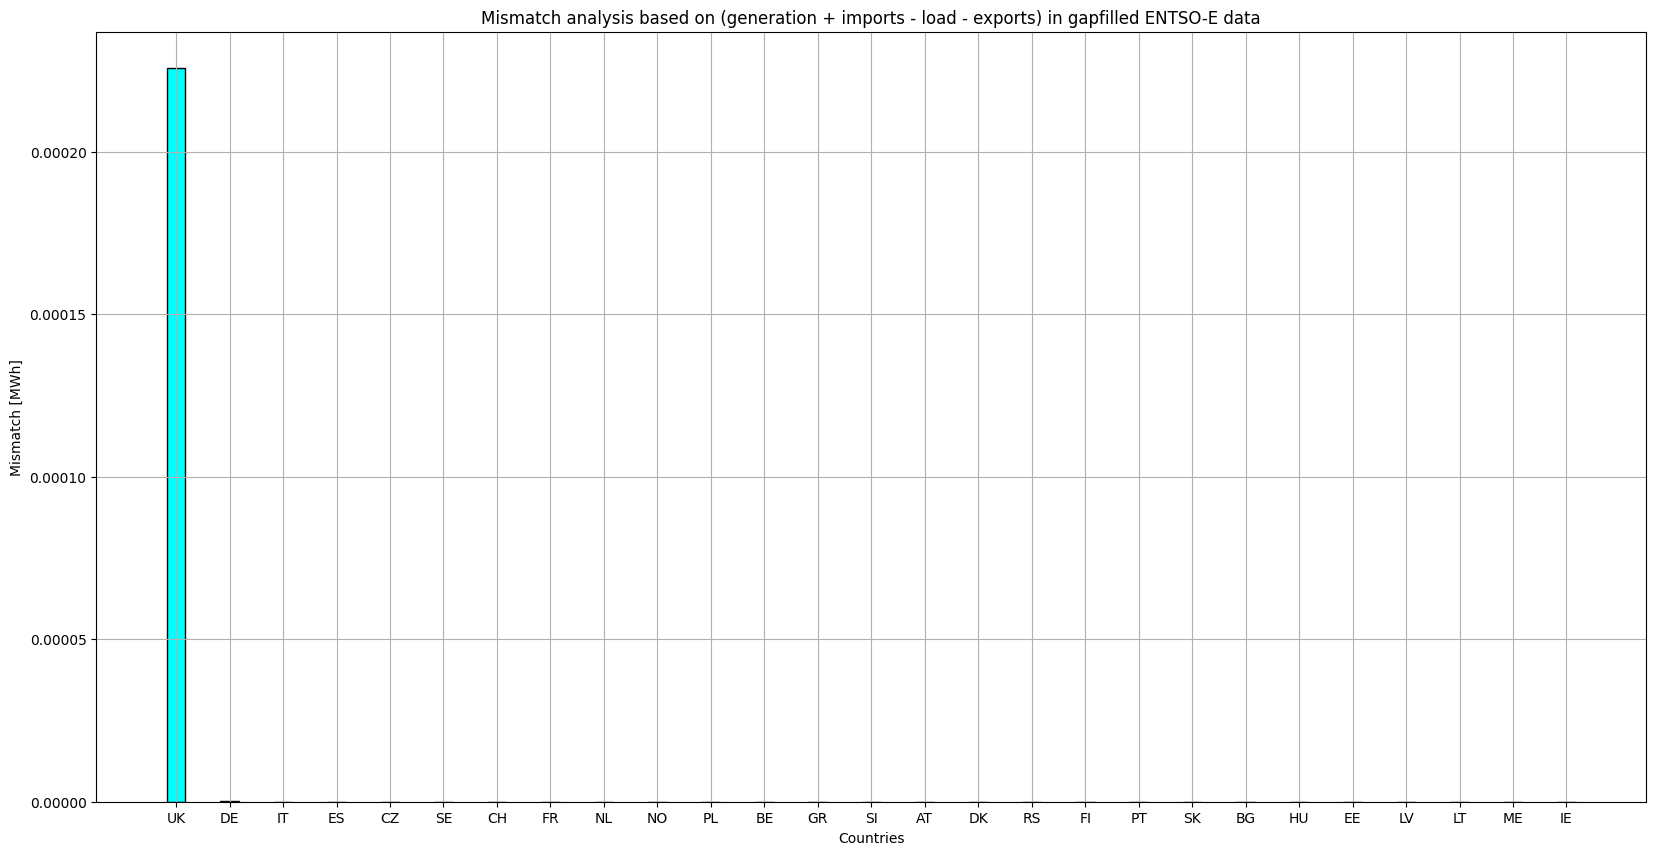

In [28]:
mismatch_gapfilled_data(abbr_list)